# Route Selection Model Weights
### Purpose of this notebook is to train the model for predicting passenger traffic between two given cities for a given year
### Weights of this model will subsequently be saved and used by the web server while selecting new route to be added to an airline's network

In [1]:
import numpy as np
import pandas as pd

import geopy.distance

import shutil
import os
from collections import OrderedDict

from sklearn import linear_model, metrics

import json

import matplotlib.pyplot as plt
import seaborn as sns

import time

## Load PreProcessor, all tier-I/II cities & PRESENT_YEAR
### We do not preprocess all data again since we assume preprocessing would have been done in CitySelection_SaveModel

In [2]:
from utils.PreProcessor import PreProcessor
preprocessor = PreProcessor(sample_names = ['AirAsia_India', 'Akasa_Air', 'Star_Air'], preprocess_all_raw_data = False)

tier_1_2_cities = [
    'Ahmedabad', 'Bengaluru', 'Mumbai', 'Pune', 'Chennai', 'Hyderabad', 'Kolkata', 'Delhi', 'Visakhapatnam', 'Guwahati', 'Patna',
    'Raipur', 'Gurugram', 'Shimla', 'Jamshedpur', 'Thiruvananthapuram', 'Bhopal', 'Bhubaneswar', 'Amritsar', 'Jaipur', 'Lucknow', 'Dehradun'
]
tier_1_2_cities = tier_1_2_cities + (
    "Guntur, Kakinada, Kurnool, Nellore, Rajamahendravaram, Vijayawada".split(', ')
) + (
    "Bilaspur, Bhilai".split(', ')
) + (
    "Anand, Bhavnagar, Dahod, Jamnagar, Rajkot, Surat, Vadodara".split(', ')
) + (
    "Faridabad, Karnal".split(', ')
) + (
    "Hamirpur".split(', ')
) + (
    "Bokaro Steel City, Dhanbad, Ranchi".split(', ')
) + (
    "Belagavi, Hubballi-Dharwad, Kalaburagi, Mangaluru, Mysuru, Vijayapura".split(', ')
) + (
    "Kannur, Kochi, Kollam, Kozhikode, Malappuram, Thrissur".split(', ')
) + (
    "Gwalior, Indore, Jabalpur, Ratlam, Ujjain".split(', ')
) + (
    "Amravati, Aurangabad, Bhiwandi, Dombivli, Jalgaon, Kolhapur, Nagpur, Nanded, Nashik, Sangli, Solapur, Vasai-Virar".split(', ')
) + (
    "Cuttack, Rourkela".split(', ')
) + (
    "Jalandhar, Ludhiana".split(', ')
) + (
    "Ajmer, Bikaner, Jodhpur".split(', ')
) + (
    "Coimbatore, Erode, Madurai, Salem, Thanjavur, Tiruchirappalli, Tirunelveli, Tiruvannamalai, Vellore".split(', ')
) + (
    "Warangal".split(', ')
) + (
    "Agra, Aligarh, Bareilly, Ghaziabad, Gorakhpur, Jhansi, Kanpur, Mathura, Meerut, Moradabad, Noida, Prayagraj, Varanasi".split(', ')
) + (
    "Asansol, Berhampore, Burdwan, Durgapur, Purulia, Siliguri".split(', ')
) + (
    "Chandigarh, Jammu, Puducherry, Srinagar".split(', ')
)

PRESENT_YEAR = 2023

**************************************
Loading PreProcessed Datasets
Loaded AirRouteDatasets
Loaded Domestic Passenger Data
Loaded Indian Railways Data
Loaded Socio-Economic Data
Loaded Monument Visitors Data
**************************************


## Load Domestic Passenger Dataset
### This is for fetching all routes for which domestic passenger data is available

In [3]:
# cities -> cities for which to collect domestic passenger data
def get_route_passenger_traffic_data(cities):
    city_to_city_mapping = dict(zip(preprocessor.city_mapping['DomesticPassengerTraffic_City'], preprocessor.city_mapping['City']))
    route_traffic = []
    for idx, row in preprocessor.total_domestic_data.iterrows():
        if((row['FROM'] in city_to_city_mapping) and (row['TO'] in city_to_city_mapping)):    # If From or To city is a tier-I/II city, then include in data (since we have only collected PCA values for those cities)
            route_traffic.append([city_to_city_mapping[row['FROM']], city_to_city_mapping[row['TO']], row['PASSENGERS']])
    route_traffic_df = pd.DataFrame(route_traffic, columns = ['From', 'To', 'Passengers_Target'])
    return route_traffic_df

route_traffic_df = get_route_passenger_traffic_data(tier_1_2_cities)
route_traffic_df['Year'] = pd.Series([PRESENT_YEAR] * route_traffic_df.shape[0])
route_traffic_df['Connecting'] = pd.Series([''] * route_traffic_df.shape[0])    # Connecting refers to whether given route has a connecting flight. Since given domestic passenger info is for direct flights, we leave this field out

# Feature Extraction

## Load Railway Connectivity Info
### We now try to info about railway connectivity between two given cities

In [4]:
# raw_route_traffic_df -> route info for which to collect railway connectivity data
def get_railways_info_features(raw_route_traffic_df):
    route_traffic_df = raw_route_traffic_df.copy()
    railway_info = []
    city_to_district_mapping = dict(zip(preprocessor.city_mapping['City'].values, preprocessor.city_mapping['StationCodeData_District'].values))
    for idx, row in route_traffic_df.iterrows():
        from_district = city_to_district_mapping[row['From']]
        to_district = city_to_district_mapping[row['To']]
        if(from_district not in preprocessor.city_to_city_train_dict):    # If railway data not available for FROM city
            railway_info.append([row['From'], row['To'], row['Year']] + [0, np.nan, np.nan])
        else:
            if(to_district not in preprocessor.city_to_city_train_dict[from_district]):    # If railway data not available for TO city
                railway_info.append([row['From'], row['To'], row['Year']] + [0, np.nan, np.nan])
            else:    # If railway data availble for both FROM & TO cities
                route_railway_info = preprocessor.city_to_city_train_dict[from_district][to_district]
                num_trains = len(route_railway_info)    # Number of trains in given route
                avg_duration = np.nanmean([x['duration'] for x in route_railway_info])    # Avg duration of train journey
                # Info about availability of different coaches in train
                third_ac = np.nansum([x['third_ac'] for x in route_railway_info])
                chair_car = np.nansum([x['chair_car'] for x in route_railway_info])
                first_class = np.nansum([x['first_class'] for x in route_railway_info])
                sleeper = np.nansum([x['sleeper'] for x in route_railway_info])
                second_ac = np.nansum([x['second_ac'] for x in route_railway_info])
                first_ac = np.nansum([x['first_ac'] for x in route_railway_info])

                # Based on https://en.wikipedia.org/wiki/Indian_Railways_coaching_stock & https://www.quora.com/What-is-the-capacity-of-normal-Indian-passenger-train, we can estimate total capacity of train based on availability of coaches
                #   first_ac -> 20 (1x20)
                #   second_ac -> 100 (2x50)
                #   third_ax -> 180 (3x60)
                #   chair_car -> 150 (75x2)
                #   sleeper -> 840 (12x70)
                #   first_class -> 20 (1x20)
                capacity = (
                    first_ac * 20 +
                    second_ac * 100 +
                    third_ac * 180 +
                    chair_car * 150 +
                    sleeper * 840 +
                    first_class * 20
                )

                # Forecasting growth of railways
                #    -> Based on https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwiQp_S3qNP9AhXIwTgGHYuaB5EQFnoECA8QAQ&url=https%3A%2F%2Findianrailways.gov.in%2Frailwayboard%2Fuploads%2Fdirectorate%2Fstat_econ%2FAnnual-Reports-2020-2021%2FAnnual-Report-English.pdf&usg=AOvVaw2YMsSpEfqTOjBD13N-ZsJl, we can also estimate how railway features are expected to grow with time
                #    -> On average, over the past decade, number of passenger coaches increased by ~1000 per year while total running track increased by ~1000 km per year
                #    -> On average, growth rate in railway connectivity & passenger capacity can be considered ~2% per year
                #    -> This linear growth rate can be used for number & capacity of trains while we assume duration of the train journey will remain constant
                num_trains = num_trains + num_trains * (2 / 100) * (row['Year'] - PRESENT_YEAR)
                capacity = capacity + capacity * (2 / 100) * (row['Year'] - PRESENT_YEAR)
                railway_info.append([row['From'], row['To'], row['Year']] + [num_trains, avg_duration, capacity])
    
    # Collecting all railway data for all routes
    railway_info_df = pd.DataFrame(railway_info, columns = ['From', 'To', 'Year', 'NumTrains_Railways', 'Duration_Railways', 'Capacity_Railways'])
    route_traffic_df = pd.merge(route_traffic_df, railway_info_df, on = ['From', 'To', 'Year'], how = 'left')
    return route_traffic_df

route_traffic_df = get_railways_info_features(route_traffic_df)

## Flight Duration Data
### We try to estimate how long a flight would take

In [5]:
OVERLAY_TIME = 120    # We assume for a connecting flight that on average a 2 hour overlay is expected. This is done to favor direct flights over connecting flights
airport_to_coords_mapping = dict(zip(preprocessor.city_mapping['AirRouteData_AirportCode'].values, preprocessor.city_mapping['Airport_City_Coords'].values))

# We fit a line between available flight distances & flight durations
# We can use this linear expression to find durations for new routes
distance_time_curve_fit = np.polyfit(preprocessor.all_network_data['Distance'].values, preprocessor.all_network_data['Time'].values, 1)

# from_airport -> city/airport from which route originates
# to_airport -> city/airport at which route ends
def get_timing(from_airport, to_airport):
    route_timing_data = preprocessor.all_network_data[(preprocessor.all_network_data['From'] == from_airport) & (preprocessor.all_network_data['To'] == to_airport)]    # Fetching data for given route
    if(route_timing_data.shape[0] == 0):    # If data for given route does not exist, we need to estimate duration of flight
        
        # Find coordinates of FROM & TO airports
        from_airport_coords = airport_to_coords_mapping[from_airport]
        from_airport_coords_lat = float(from_airport_coords.split(',')[0])
        from_airport_coords_lon = float(from_airport_coords.split(',')[1])
        from_airport_coords = (from_airport_coords_lat, from_airport_coords_lon)
        to_airport_coords = airport_to_coords_mapping[to_airport]
        to_airport_coords_lat = float(to_airport_coords.split(',')[0])
        to_airport_coords_lon = float(to_airport_coords.split(',')[1])
        to_airport_coords = (to_airport_coords_lat, to_airport_coords_lon)

        # Calculate distance between two airports and estimate duration using our distance-duration linear expression
        route_distance = geopy.distance.geodesic(from_airport_coords, to_airport_coords).miles
        route_timing = route_distance * distance_time_curve_fit[0] + distance_time_curve_fit[1]

    else:    # If data for given route exists, simply use the duration info
        assert(route_timing_data['Time'].nunique() == 1)
        route_distance = route_timing_data['Distance'].mean()
        route_timing = route_timing_data['Time'].mean()
    
    return route_timing, route_distance    # Return total distance & duration of flight

# raw_route_traffic_df -> route info for which to collect railway connectivity data
def get_route_timing_features(raw_route_traffic_df):

    route_traffic_df = raw_route_traffic_df.copy()
    route_timings = []
    city_to_airport_mapping = dict(zip(preprocessor.city_mapping['City'].values, preprocessor.city_mapping['AirRouteData_AirportCode'].values))
    for idx, row in route_traffic_df.iterrows():
        from_airport = city_to_airport_mapping[row['From']]
        to_airport = city_to_airport_mapping[row['To']]
        connecting = row['Connecting']
        if(connecting == ''):    # If no connecting flight, find direct duration of flight
            route_timing = get_timing(from_airport, to_airport)[0]
        else:    # If connecting flight, add durations of both flights + overlay time
            connecting_airport = city_to_airport_mapping[connecting]
            route_timing = get_timing(from_airport, connecting_airport)[0] + get_timing(connecting_airport, to_airport)[0] + OVERLAY_TIME
        route_timings.append(route_timing)

    # Collect data for all routes
    route_traffic_df['Duration_AirRoute'] = pd.Series(route_timings)
    route_traffic_df['NumTrains_Railways'] = route_traffic_df['NumTrains_Railways'].fillna(0)
    return route_traffic_df

route_traffic_df = get_route_timing_features(route_traffic_df)

## PCA values for FROM & TO cities
### We use the same PCA values for each city from CitySelection analysis
### These PCA values will hopefully represent the various macro-economic factors of each city

In [6]:
# Collect current PCA values of each city
pca_vals_df = pd.read_csv(f'PreProcessed_Datasets/Models/Present_Features/data_pca_X.csv')
pca_cols = ['City_' + x for x in pca_vals_df.columns if x != 'City']
pca_vals_df.columns = pca_cols + ['City']
pca_vals_df['Year'] = pd.Series([PRESENT_YEAR] * pca_vals_df.shape[0])

total_pca_vals_df = pca_vals_df

In [7]:
# raw_route_traffic_df -> route info for which to collect railway connectivity data
def get_pca_vals_features(raw_route_traffic_df):
    route_traffic_df = raw_route_traffic_df.copy()
    # Fetch PCA values for FROM & TO cities
    route_traffic_df = pd.merge(route_traffic_df, total_pca_vals_df, left_on = ['From', 'Year'], right_on = ['City', 'Year'], how = 'left')
    route_traffic_df = pd.merge(route_traffic_df, total_pca_vals_df, left_on = ['To', 'Year'], right_on = ['City', 'Year'], how = 'left', suffixes = ('_pca_vals_FROM', '_pca_vals_TO'))

    route_traffic_df = route_traffic_df.drop(['City_pca_vals_TO', 'City_pca_vals_FROM'], axis = 1)
    for col in pca_cols:
        # For FROM & TO city, try to find average & difference between both cities' PCA values
        # Intuition is to cover both cases to see whether some pattern exists - route from Major to Minor city & route from both major/minor cities
        route_traffic_df[f'{col}_avg_PCA'] = (route_traffic_df[f'{col}_pca_vals_FROM'] + route_traffic_df[f'{col}_pca_vals_TO']) / 2
        route_traffic_df[f'{col}_diff_PCA'] = (route_traffic_df[f'{col}_pca_vals_FROM'] - route_traffic_df[f'{col}_pca_vals_TO'])
        route_traffic_df = route_traffic_df.drop([f'{col}_pca_vals_FROM', f'{col}_pca_vals_TO', f'{col}_pca_vals_FROM', f'{col}_pca_vals_TO'], axis = 1)

    return route_traffic_df

route_traffic_df = get_pca_vals_features(route_traffic_df)

In [8]:
# Collect X & y features
y_features = [x for x in route_traffic_df.columns if x.endswith('_Target')]
X_features = [x for x in route_traffic_df.columns if (x.endswith('_PCA')) or (x.endswith('_AirRoute')) or (x.endswith('_Railways'))]

In [9]:
# Trimming data for model training - Removing routes having no target variable
# Also standardizing data
valid_route_traffic_df = route_traffic_df.copy()
cols_standardization_vals = {}
for col_idx, col in enumerate(valid_route_traffic_df.columns):
    if((col in X_features) or (col in y_features)):
        if(col in y_features):
            to_drop_idx = pd.isnull(valid_route_traffic_df[col])
            to_drop_idx = to_drop_idx[to_drop_idx == True].index
            valid_route_traffic_df = valid_route_traffic_df.drop(to_drop_idx, axis = 0)
        elif(col in X_features):
            col_mean = np.nanmean(valid_route_traffic_df[col].values)
            valid_route_traffic_df[col] = valid_route_traffic_df[col].fillna(col_mean)
        col_mean = valid_route_traffic_df[col].mean()
        col_std = valid_route_traffic_df[col].std()
        valid_route_traffic_df[col] = (valid_route_traffic_df[col] - col_mean) / (col_std + 1e-20)
        cols_standardization_vals[col] = {'mean': col_mean, 'std': col_std}

In [10]:
# Saving the column standardization values (i.e. column mean & std)
# This will be used when creating test dataset in web server
with open(f'./PreProcessed_Datasets/Models/RouteSelection_cols_standardization.json', 'w') as save_file:
    json.dump(cols_standardization_vals, save_file)

In [11]:
# Standardized X & y datasets
data_X = valid_route_traffic_df[X_features].values
data_y = valid_route_traffic_df[y_features].values[:, 0]

data_cities = [(x[0], x[1]) for x in valid_route_traffic_df[['From', 'To']].values]    # Also collecting FROM & TO cities of each route

In [12]:
print(f"X & y dataset shapes: {data_X.shape}, {data_y.shape}")

X & y dataset shapes: (1024, 20), (1024,)


Coefficients:  [0.05472721870889303, 0.03508471668303333, 0.014484026354109234, 0.05689917313999606, 0.29435002501373986, 0.0023281158792980753, 0, 0, 0.3354968344604925, 0.0017711479429114328, 0.09544987600347105, 0.00034598780893811703, 0.5641558644194823, 0.000591426297305951, 0.25467030342269675, 0.00032537137649537223, 0.1600198625476444, 0.003115602149243036, 0.40626395186957737, 0.00012128745016193197]


/home/sakshat/anaconda3/envs/R2DataLabsHackathonPython/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/sakshat/anaconda3/envs/R2DataLabsHackathonPython/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


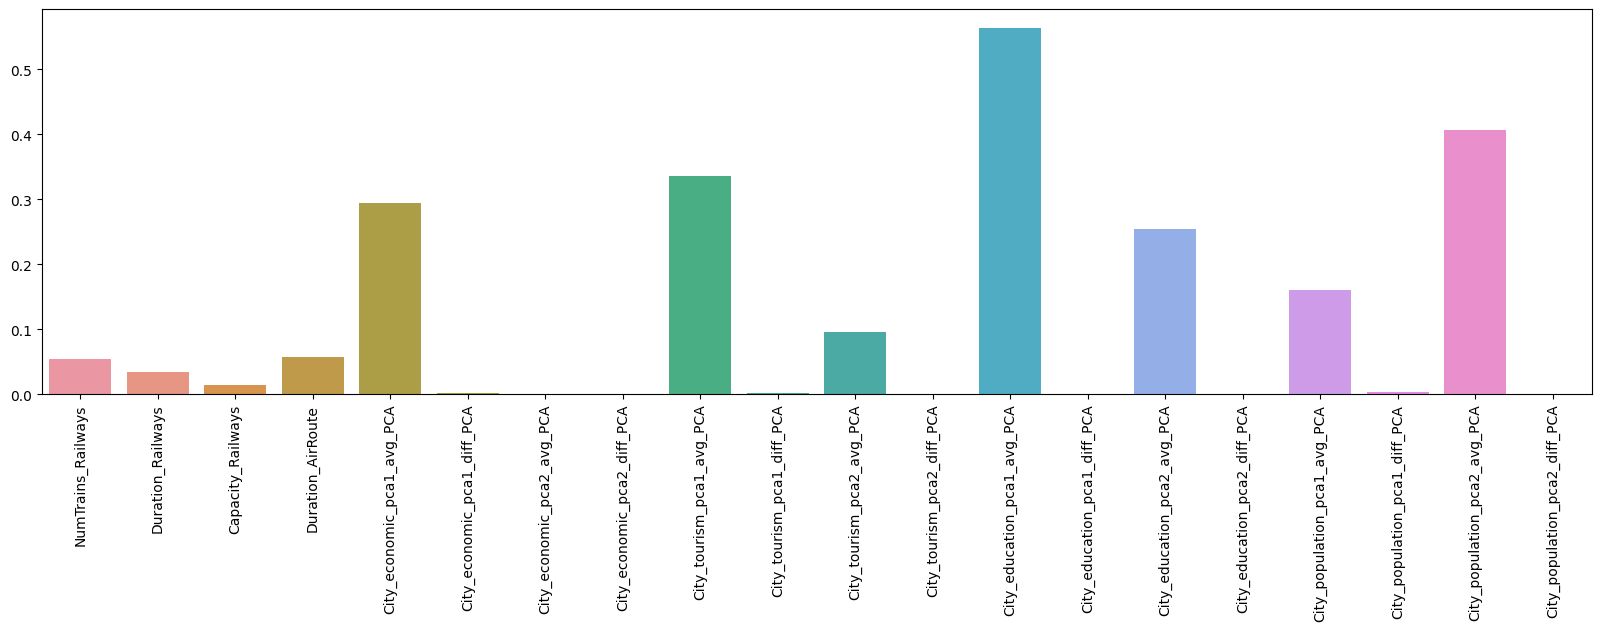

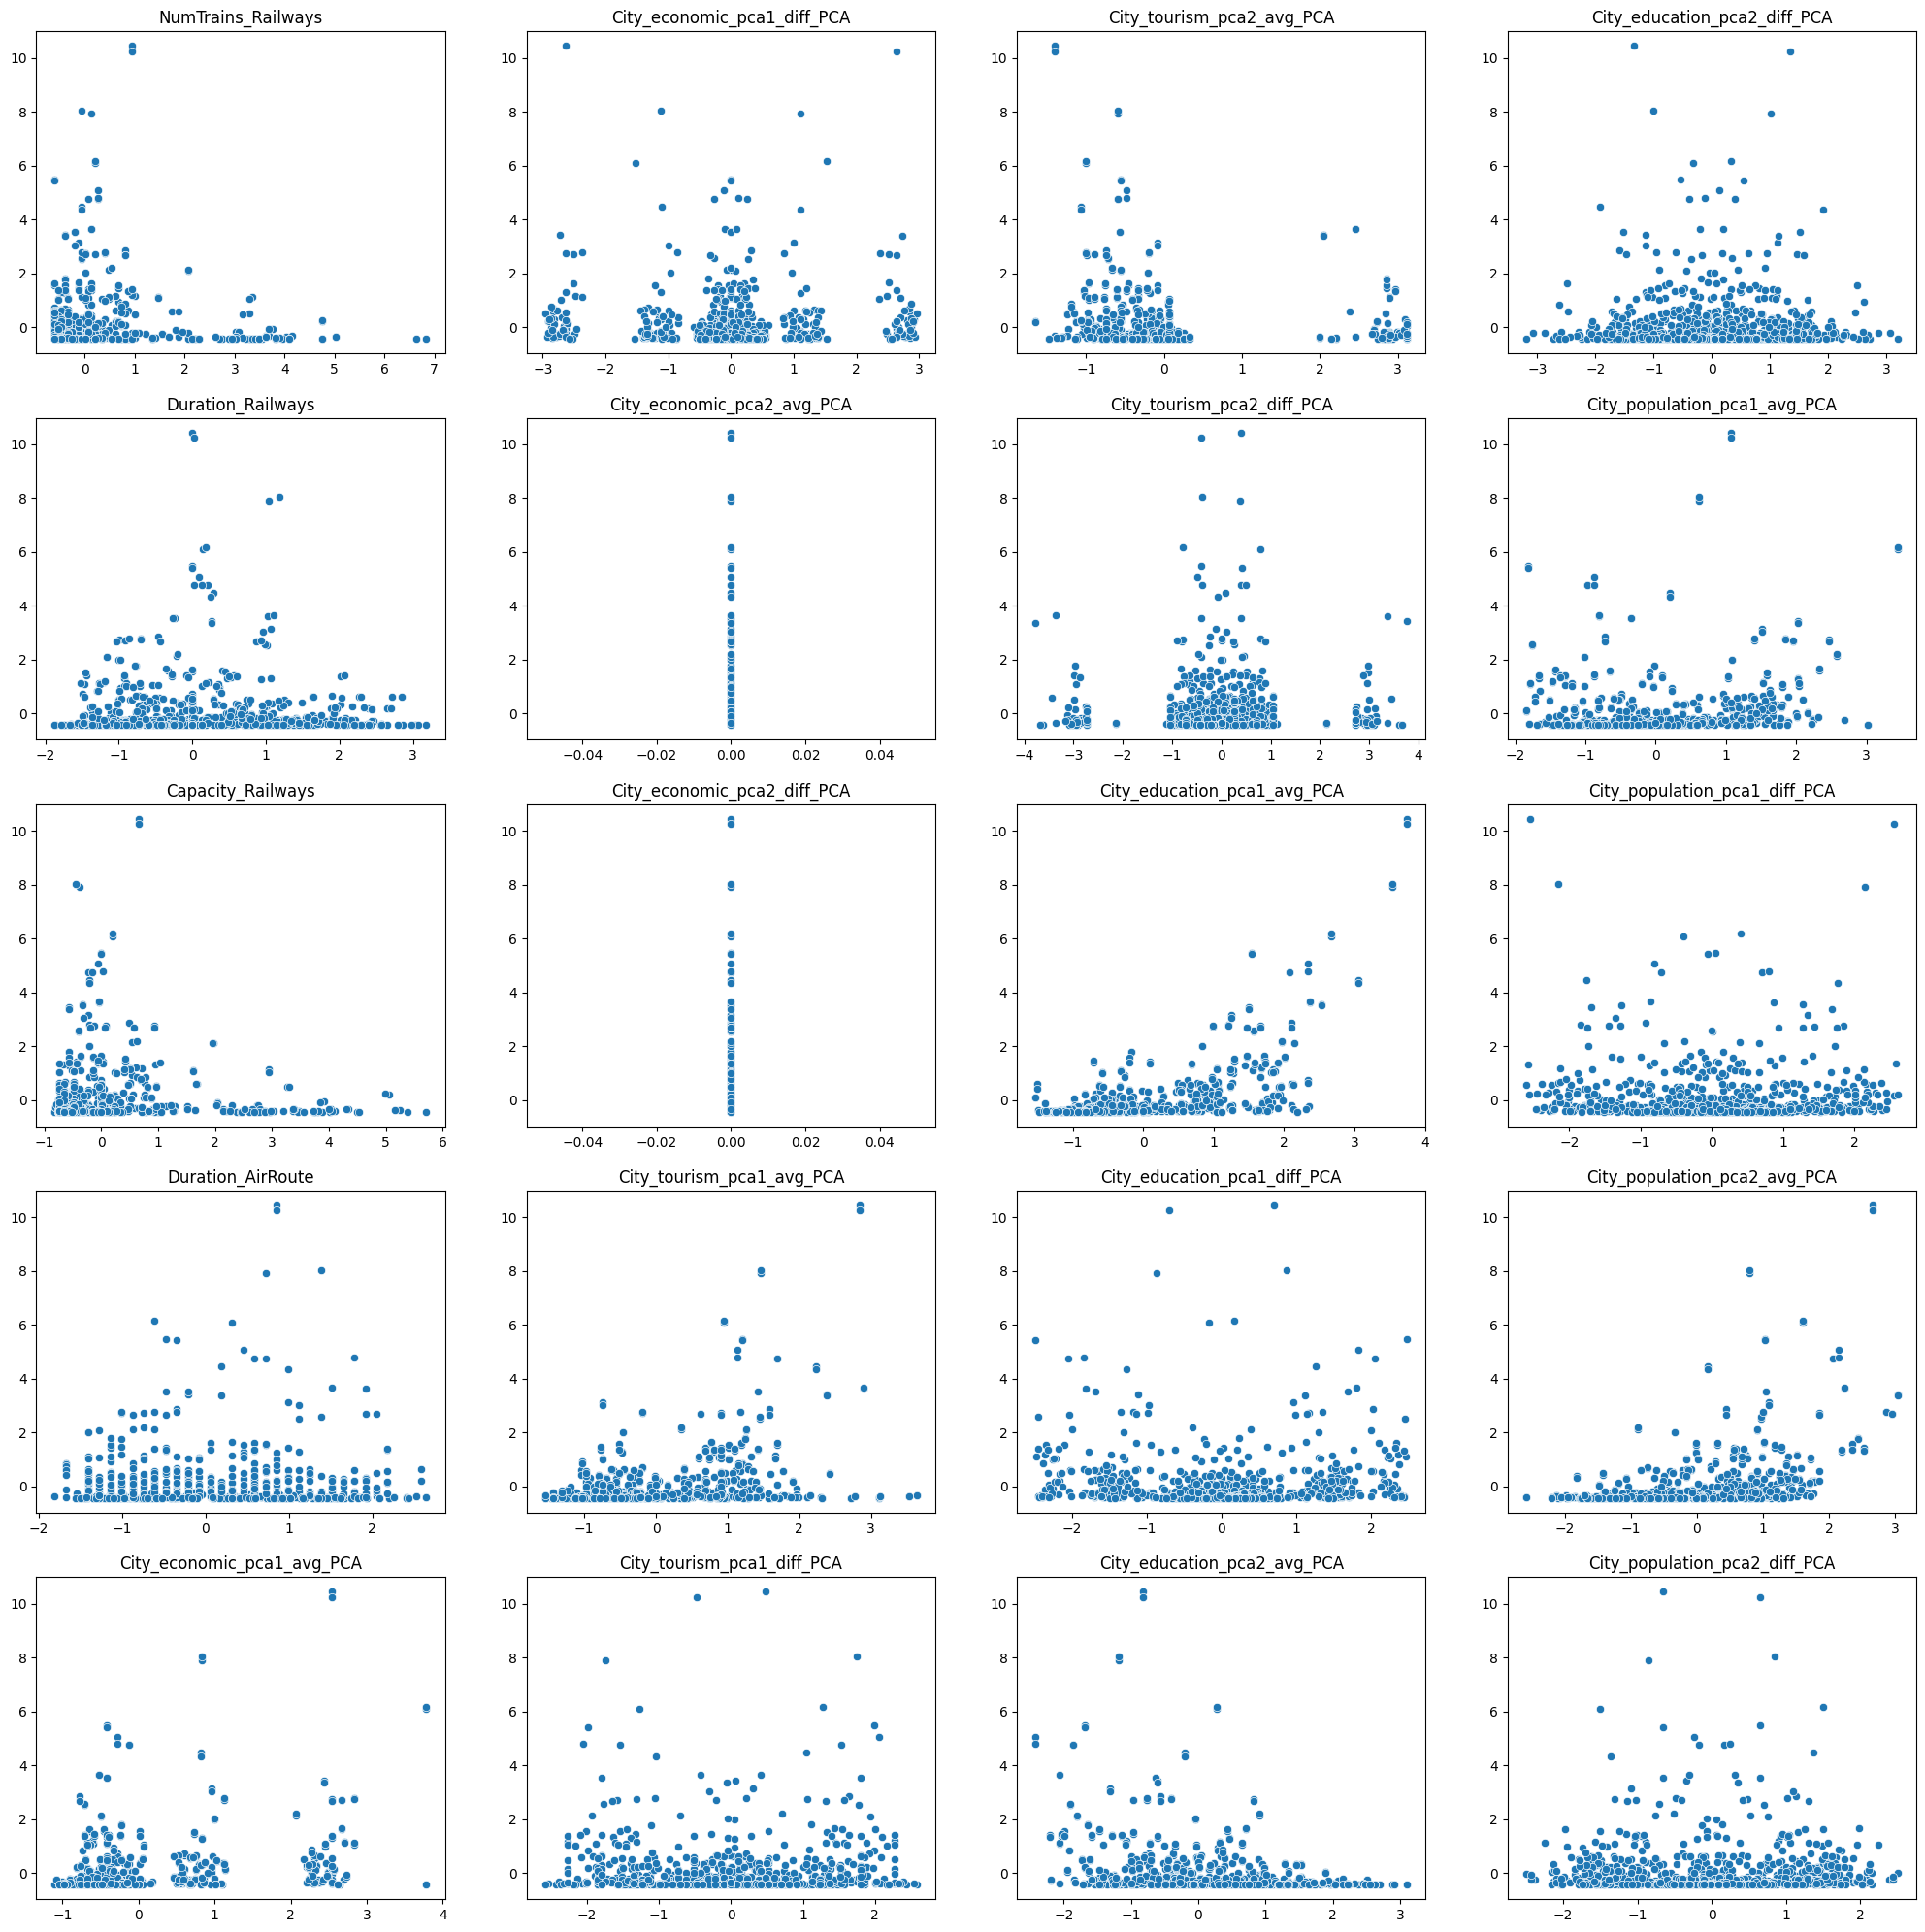

In [13]:
# Plotting Correlations for understanding linearity between features and target variable
corr_coefs = []
for idx in range(len(X_features)):
    corr = np.abs(np.corrcoef(data_X[:, idx], data_y)[0, 1])
    if(pd.isnull(corr)):
        corr = 0
    corr_coefs.append(corr)
print('Coefficients: ', corr_coefs)
fig, ax = plt.subplots(1, 1, figsize = (20, 5))
sns.barplot(x = X_features, y = corr_coefs, ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.show()
fig, axes = plt.subplots(5, 4, figsize = (25, 25))
for col_idx, col in enumerate(X_features):
    sns.scatterplot(x = data_X[:, col_idx], y = data_y, ax = axes[col_idx % 5, col_idx // 5])
    axes[col_idx % 5, col_idx // 5].set_title(X_features[col_idx])
plt.show()

In [14]:
# Loading Linear Regression model
model = linear_model.LinearRegression()

In [15]:
# Performing cross-validation for 20 iterations to judge performance of model
maes = []
rmses = []
train_test_split_idx = int(0.8 * data_X.shape[0])
all_idx = np.arange(data_X.shape[0])
for train_iter in range(20):
    np.random.shuffle(all_idx)
    train_idx = all_idx[:train_test_split_idx]; test_idx = all_idx[train_test_split_idx:]
    model = linear_model.LinearRegression()
    model.fit(data_X[train_idx], data_y[train_idx])
    target_mean = cols_standardization_vals[y_features[0]]['mean']
    target_std = cols_standardization_vals[y_features[0]]['std']
    true = data_y[test_idx] * target_std + target_mean
    pred = model.predict(data_X[test_idx]) * target_std + target_mean
    pred[pred < 0] = 0
    mae = metrics.mean_absolute_error(true, pred)
    rmse = np.sqrt(metrics.mean_squared_error(true, pred))
    maes.append(mae)
    rmses.append(rmse)
print(f"Avg MAE: {np.mean(maes):.2f}")
print(f"Avg RMSE: {np.mean(rmses):.2f}")

Avg MAE: 91170.24
Avg RMSE: 187017.79


In [16]:
# Fitting linear regression model with all datas and extracting coefficients of model
model = linear_model.LinearRegression()
model.fit(data_X, data_y)
model_coefs = OrderedDict(zip(['intercept'] + [*X_features], [model.intercept_] + [*model.coef_]))

In [17]:
# Saving coefficients of Linear Regression model
# This will be used when making predictions in web server
import json
with open(f'./PreProcessed_Datasets/Models/RouteSelectionModel_coefs.json', 'w') as save_file:
    json.dump(model_coefs, save_file)